In [41]:
import numpy as np
import pandas as pd
from numpy import linalg as LA

In [42]:
def sigmoid(x, derivative=False):

    if x > 100:
        sigm = 1.
    elif x < -100:
        sigm = 0.
    else:
        sigm = 1. / (1. + np.exp(-x))

    if derivative:
        return sigm * (1. - sigm)
    return sigm

In [45]:
def config(data, skill_dim, concept_dim, lambda_s, lambda_t,
           penalty_weight, tol=1e-3, trade_off_example=0.1, max_iter=40, lr=0.005):

    config = {
        'num_users': data['num_users'],
        'num_questions': data['num_quizs'],
        'num_discussions': data['num_disicussions'],
        'num_attempts': data['num_attempts'],
        'num_skills': skill_dim,
        'num_concepts': concept_dim,
        'lambda_s': lambda_s,
        'lambda_t': lambda_t,
        'penalty_weight': penalty_weight,
        'trade_off_example': trade_off_example,
        'lr': lr,
        'tol': tol,
        'max_iter': max_iter,
    }

    train_set = []
    for (stud, ques, obs, att, res) in data['train']:
        train_set.append((int(stud), int(att), int(ques), float(obs), int(res)))
    config['train'] = train_set

    test_set = []
    for (stud, ques, obs, att, res) in data['test']:
        if int(att) < 100:
            test_set.append((int(stud), int(att), int(ques), float(obs), int(res)))
    
    config['num_attempts'] = 19
    config['test'] = test_set

    return config

In [54]:

#-------------------------------------- Hiperparametros -------------------------------------------------

skill_dim = 3
concept_dim = 5
lambda_s = 0
lambda_t = 0
penalty_weight = 0.01
lr = 0.005
max_iter = 40 
trade_off_example = 0.1
tol = 1e-3


#----------------------------------- Lectura de la Data ----------------------------------------------

dataRN = pd.read_csv('Datos.csv')


dataRN = dataRN.sample(frac=1).reset_index(drop = True)

data_train = []
for (i, j, k, l, m) in dataRN.values:
    data_train.append([i, j, k, l, m])

data_test = data_train[:int(len(data_train) * 0.2)]
for x in data_test:
    data_train.remove(x)

data = {}

data['num_users'] = 17
data['num_quizs'] = 12 
data['num_disicussions'] = 8
data['num_attempts'] = 19
data['train'] = data_train
data['test'] = data_test


#-------------------------------- Asignacion del diccionario config ---------------------------------

model_config = config(data, skill_dim, concept_dim, lambda_s, lambda_t,
                          penalty_weight, lr=lr, max_iter=max_iter, trade_off_example=trade_off_example)


#------------------------------------ Inicializacion de matrices y variables-------------------------------

test_set = model_config['test']
train_data = model_config['train']
num_users = model_config['num_users']
num_skills = model_config['num_skills']
num_attempts = model_config['num_attempts']
num_concepts = model_config['num_concepts']
num_questions = model_config['num_questions']
lambda_s = model_config['lambda_s']
lambda_t = model_config['lambda_t']
penalty_weight = model_config['penalty_weight']
lr = model_config['lr']
tol = model_config['tol']
max_iter = model_config['max_iter']

num_examples = model_config['num_discussions']
trade_off_e = model_config['trade_off_example']

binarized_example = True

loss_list = []
val_data = []

S = np.random.random_sample((num_users, num_skills))
T = np.random.random_sample((num_skills, num_attempts,num_concepts))
Q = np.random.random_sample((num_concepts, num_questions)) # Materiales evaluados
E = np.random.random_sample((num_concepts, num_examples))  # Materiales no evaluados

total_test_count = 0
sum_square_error, sum_abs_error = [0.] * 2


#---------------------------------- Entrenamiento -------------------------------------------------

for ciclo in range(0, 30): 
    
    lr = lr

    train_question = [] 
    for student, attempt, question, obs, resource in train_data:
        if resource == 0:
            train_question.append((student, attempt, question, obs, resource))

    np.random.shuffle(train_question)
    
    val_data = train_question[:int(len(train_question) * 0.2)]  # se toma el 20% para data de validacion, esta data cambia
    train_question_size = len(train_question) - len(val_data)   # por cada iteracion
    
    for record in val_data:
        try:
            train_data.remove(record)
        except:
            print(record)
            print(record in val_data)
            print(record in train_data)
            print(sorted(train_data, key=lambda x:x[1]))


    iter = 0
    val_q_rmse_list = [1.]
    converge = False
    min_iters = 35


    while not converge:

        np.random.shuffle(train_data)

        if iter > 0:
            S = best_S
            Q = best_Q
            T = best_T
            E = best_E
    
        for (student, attempt, index, obs, resource) in train_data:
            
            # ----------- Paso de actualizacion de Q
            if resource == 0:
            
                grad_q = np.zeros_like(Q[:, index])
                if obs != None:

                    pred = np.dot(np.dot(S[student, :], T[:, attempt, :]), Q[:, index])
                    grad_q = -2. * (obs - pred) * np.dot(S[student, :], T[:, attempt, :])

                Q[:, index] -= lr * grad_q
                Q[:, index][Q[:, index] < 0.] = 0.

                sum = np.sum(Q[:, index])
                if sum != 0:
                    Q[:, index] /= sum
            
            # ----------- Paso de actualizacion de E
            elif resource == 1:

                grad_e = np.zeros_like(E[:, index])
                if obs != None:
                    pred = np.dot(np.dot(S[student, :], T[:, attempt, :]), E[:, index])

                    if binarized_example:
                        grad_e = -2. * trade_off_e * (obs - pred) * pred * (1. - pred) * np.dot(
                            S[student, :], T[:, attempt, :])
                    else:
                        grad_e = -2. * trade_off_e * (obs - pred) * np.dot(S[student, :],
                                                                            T[:, attempt, :])

                E[:, index] -= lr * grad_e
                E[:, index][E[:, index] < 0.] = 0.

                sum = np.sum(E[:, index])
                if sum != 0:
                    E[:, index] /= sum 

    
            # ----------- Paso de actualizacion de S
            grad_s = np.zeros_like(S[student, :])
            if obs != None:
                if resource == 0:

                    pred = np.dot(np.dot(S[student, :], T[:, attempt, :]), Q[:, index])

                    grad_s = -2. * (obs - pred) * np.dot(T[:, attempt, :], Q[:, index])

                elif resource == 1:
                    
                    pred = np.dot(np.dot(S[student, :], T[:, attempt, :]), E[:, index])

                    if binarized_example:
                        grad_s = -2. * trade_off_e * (obs - pred) * pred * (1. - pred) * np.dot(
                            T[:, attempt, :], E[:, index])
                    else:
                        grad_s = -2. * trade_off_e * (obs - pred) * np.dot(T[:, attempt, :],
                                                                                E[:, index])
            grad_s += 2. * lambda_s * S[student, :]


            S[student, :] -= lr * grad_s

            if lambda_s == 0.:
                S[student, :][S[student, :] < 0.] = 0.
                sum = np.sum(S[student, :])

            if sum != 0:
                S[student, :] /= sum

            # ----------- Paso de actualizacion de T
            grad_t = np.zeros_like(T[:, attempt, :])
            if obs != None:
                
                if resource == 0:
                    pred = np.dot(np.dot(S[student, :], T[:, attempt, :]), Q[:, index])

                    grad_t = -2. * (obs - pred) * np.outer(S[student, :], Q[:, index])

                elif resource == 1:

                    pred = np.dot(np.dot(S[student, :], T[:, attempt, :]), E[:, index])

                    if binarized_example:
                        grad_t = -2. * trade_off_e * (obs - pred) * pred * (1. - pred) * np.outer(
                            S[student, :],
                            E[:, index])
                    else:
                        grad_t = -2. * trade_off_e * (obs - pred) * np.outer(S[student, :],
                                                                                E[:, index])
            grad_t += 2. * lambda_t * T[:, attempt, :]

            if resource == 0:
                if attempt == 0:
                    diff = T[:, attempt + 1, :] - T[:, attempt, :]
                    diff[diff > 0.] = 0.

                    # Penalizacion
                    diff[diff < 0.] = -1.
                    grad_t -= penalty_weight * diff
                        
                elif attempt == num_attempts - 1:
                    gap = T[:, attempt, :] - T[:, attempt - 1, :]
                    gap[gap > 0.] = 0.

                    # Penalizacion
                    gap[gap < 0.] = 1.
                    grad_t -= penalty_weight * gap
                    
                else:
                    diff = T[:, attempt, :] - T[:, attempt - 1, :]
                    diff[diff > 0.] = 0.

                    # Penalizacion
                    diff[diff < 0.] = 1.
                    grad_t -= penalty_weight * diff
                    

                    diff = T[:, attempt + 1, :] - T[:, attempt, :]
                    diff[diff > 0.] = 0.

                    # Penalizacion
                    diff[diff < 0.] = -1.

            elif resource == 1:
                if attempt == 0:
                    diff = T[:, attempt + 1, :] - T[:, attempt, :]
                    diff[diff > 0.] = 0.

                    # Penalizacion
                    diff[diff < 0.] = -1.
                    grad_t -= penalty_weight * diff
                    
                    
                elif attempt == num_attempts - 1:
                    diff = T[:, attempt, :] - T[:, attempt - 1, :]
                    diff[diff > 0.] = 0.

                    # Penalizacion
                    diff[diff < 0.] = 1.
                    grad_t -= penalty_weight * diff

                else:
                    diff = T[:, attempt, :] - T[:, attempt - 1, :]
                    diff[diff > 0.] = 0.

                    # Penalizacion
                    diff[diff < 0.] = 1.
                    grad_t -= penalty_weight * diff

                    diff = T[:, attempt + 1, :] - T[:, attempt, :]
                    diff[diff > 0.] = 0.

                    # Penalizacion
                    diff[diff < 0.] = -1.
                    grad_t -= penalty_weight * diff

            T[:, attempt, :] -= lr * grad_t


        #----------- Calculo de la funcion de costo
        
        #----- L1
        loss, square_loss = 0., 0.
        square_loss_q, square_loss_l, square_loss_e = 0., 0., 0.
        q_count, l_count, e_count = 0., 0., 0.

        for (student, attempt, question, obs, resource) in train_data:
            
            if resource == 0:

                """
                    Se hace le producto matricial entre S y T y luego con Q
                    En la matriz S tomamos la que corresponde al estudiante student
                    En la matriz T tomamos de cada capa el intento attempt
                    En la matriz Q tomamos la columna question de cada concepto
                """
                pred = np.dot(np.dot(S[student, :], T[:, attempt, :]), Q[:, question])

                square_loss_q += (obs - pred) ** 2
            
                q_count += 1

            elif resource == 1:
            
                pred = np.dot(np.dot(S[student, :], T[:, attempt, :]), E[:, question])

                if binarized_example:
                    pred = sigmoid(pred)

                square_loss_e += (obs - pred) ** 2
                e_count += 1

        square_loss = square_loss_q + trade_off_e * square_loss_e

        """
            Ahora calculamos el error de las regularizaciones
            Aplicamos regularizacion a S y T
        """

        reg_S = LA.norm(S) ** 2  # norma 2
        reg_T = LA.norm(T) ** 2  # norma 2

        reg_loss = lambda_s * reg_S + lambda_t * reg_T
        
        loss = square_loss + reg_loss

        q_rmse = np.sqrt(square_loss_q / q_count) if q_count != 0 else 0. 
        e_rmse = np.sqrt(trade_off_e * square_loss_e / e_count) if e_count != 0 else 0.

        # --- Penalizacion dada por L2            
        penalty = 0.
        for (student, attempt, index, obs, resource) in train_data:
            if attempt >= 1:
                gap = T[:, attempt, :] - T[:, attempt - 1, :] 
                gap[gap > 0.] = 0. 
                if resource == 0:   
                    diff = np.dot(np.dot(S[student, :], gap), Q[:, index])
                elif resource == 1:                                       
                    diff = np.dot(np.dot(S[student, :], gap), E[:, index])
            
                penalty -= penalty_weight * diff
                
        loss += penalty

        #------- Termina la funcion de costo

        """
        La data de validacion en cada iteracion es tomada
        de forma aleatoria. Esta data solo contiene materiales del tipo evaluado (resource = 0).
        Ademas utiliza las matrices S, T, Q y E optimizadas
        ya que pasaron por el proceso del descenso de gradiente estocastico.
        Por lo tanto, siempre tenemos distintos errores
        """
        
        val_q_count, val_q_rmse, abs_error = [0.] * 3

        for (student, attempt, question, obs, resource) in val_data: 
            if resource == 0:
                
                val_q_count += 1.
                
                pred = np.dot(np.dot(S[student, :], T[:, attempt, :]), Q[:, question])
     
                val_q_rmse += (obs - pred) ** 2
                abs_error += abs(obs - pred)

        if val_q_count == 0:
            val_q_count, val_q_rmse, abs_error = [0.] * 3
        else:
            val_q_rmse = np.sqrt(val_q_rmse / val_q_count)
            mae = abs_error / val_q_count

        #------------------    

        # Criterios de Parada
        if iter == max_iter:
            loss_list.append(loss)
            converge = True
            count_max_iter += 1

        elif iter >= min_iters and abs(val_q_rmse - val_q_rmse_list[-1]) < tol:
            loss_list.append(loss)
            converge = True
 
        elif iter >= min_iters and val_q_rmse >= np.mean(val_q_rmse_list[-3:]):
            converge = True
         
        elif iter >= min_iters and loss >= np.mean(loss_list[-3:]):
            converge = True

        elif val_q_rmse >= val_q_rmse_list[-1]:
            loss_list.append(loss)
            val_q_rmse_list.append(val_q_rmse)
            iter += 1                           

        else:
            loss_list.append(loss)
            val_q_rmse_list.append(val_q_rmse)
            iter += 1

        best_S = S
        best_T = T
        best_Q = Q
        best_E = E

    for record in val_data:  # Estamos fuera del While. La data que quitamos de entreno la volvemos a colocar
        train_data.append(record)
        
        #--------------- Termina training() -----------------


#-------------------------- testing() --------------------------

    val_q_count, val_q_rmse, abs_error = [0.] * 3

    for (student, attempt, question, obs, resource) in test_set:
        if resource == 0:

            val_q_count += 1.
            
            pred = np.dot(np.dot(S[student, :], T[:, attempt, :]), Q[:, question])
    
            val_q_rmse += (obs - pred) ** 2
            abs_error += abs(obs - pred)

    if val_q_count == 0:
        val_q_count, val_q_rmse, abs_error = [0.] * 3
    else:
        val_q_rmse = np.sqrt(val_q_rmse / val_q_count)
        mae = abs_error / val_q_count
        
    test_count, _rmse, _mae = val_q_count, val_q_rmse, mae

    sum_square_error += (_rmse ** 2) * test_count # esto es solo suma((obs - pred) ** 2)
    sum_abs_error += _mae * test_count
    total_test_count += test_count


rmse = np.sqrt(sum_square_error / total_test_count) # root mean square error datos de testing
mae = sum_abs_error / total_test_count  # mean absolute error datos de test

print(f'\nRMSE: {rmse}')
print(f'\nMAE: {mae}')

print('\nTermino satisfactoriamente....\n')

S = best_S
Q = best_Q
T = best_T
E = best_E


RMSE: 0.2379254225855171

MAE: 0.17730242741580224

Termino satisfactoriamente....



In [52]:
S

array([[2.23763539e-01, 7.76222648e-01, 1.38131054e-05],
       [4.49710155e-01, 2.35913933e-01, 3.14375912e-01],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.99618673e-01, 2.64008114e-01, 4.36373214e-01],
       [6.23460614e-01, 2.66501170e-04, 3.76272885e-01],
       [8.78140770e-04, 1.13517946e-03, 9.97986680e-01],
       [2.77917469e-01, 3.06471489e-01, 4.15611042e-01],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [8.06012524e-06, 6.41540097e-01, 3.58451843e-01],
       [3.43125983e-01, 3.75323291e-01, 2.81550726e-01],
       [3.19639111e-01, 3.64268744e-01, 3.16092145e-01],
       [3.30811958e-01, 3.14112361e-01, 3.55075681e-01],
       [3.28740994e-01, 3.21534446e-01, 3.49724559e-01],
       [3.21379634e-01, 3.37117238e-01, 3.41503128e-01],
       [2.95948016e-01, 3.51409691e-01, 3.52642293e-01],
       [9.99582232e-01, 4.17768281e-04, 0.00000000e+00]])

In [35]:
data = train_data + test_set

---

## Clusters

In [36]:
x = S[:, 0].tolist()
y = S[:, 1].tolist()
z = S[:, 2].tolist()

In [37]:
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

In [38]:
mpl.style.use('seaborn-paper')

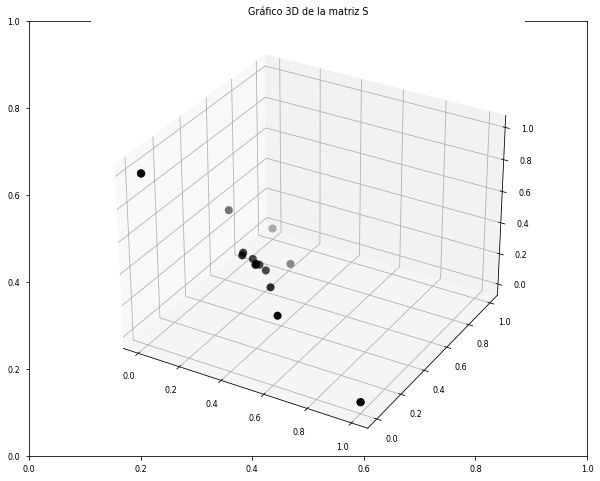

<Figure size 460.8x316.8 with 0 Axes>

In [39]:
# importamos las librerias necesarias
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

# Creamos la figura
fig = plt.figure(figsize=(10,8))

plt.title("Gráfico 3D de la matriz S")
# Creamos el plano 3D
ax1 = fig.add_subplot(projection='3d')

# Definimos los datos de prueba
x = S[:, 0].tolist()
y = S[:, 1].tolist()
z = S[:, 2].tolist()

colores=['blue','red','green','blue','cyan','yellow','orange','black','pink','brown','purple']
asignar=[]


ax1.scatter(x, y, z, c='black', s=60, marker='o')

# Agregamos los puntos en el plano 3D
#ax1.scatter(x, y, z, c='g', marker='o')
#ax1.scatter(x2, y2, z2, c ='r', marker='o')

#plt.fig

#ax1.view_init(30, angle)

# Mostramos el gráfico
plt.show()


#for angle in range(0, 360):
    #ax1.view_init(30, angle)
    #plt.draw()
    #plt.pause(.001)
    


plt.savefig('matrizS.png')

In [19]:
from sklearn.cluster import KMeans

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


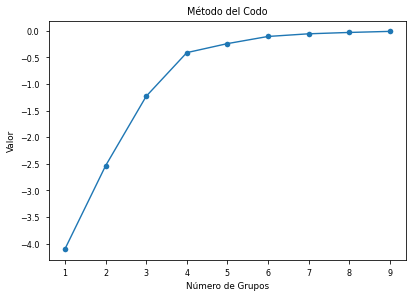

In [20]:
Nc = range(1, 10)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(S).score(S) for i in range(len(kmeans))]
score
plt.plot(Nc,score, marker = 'o')
plt.xlabel('Número de Grupos')
plt.ylabel('Valor')
plt.title('Método del Codo')
plt.savefig('metodo_codo.png')
plt.show()


In [21]:
kmeans = KMeans(n_clusters=2).fit(S)
centroids = kmeans.cluster_centers_
print(centroids)

[[2.54333490e-01 3.52621582e-01 3.93044928e-01]
 [9.99791116e-01 2.08884140e-04 0.00000000e+00]]


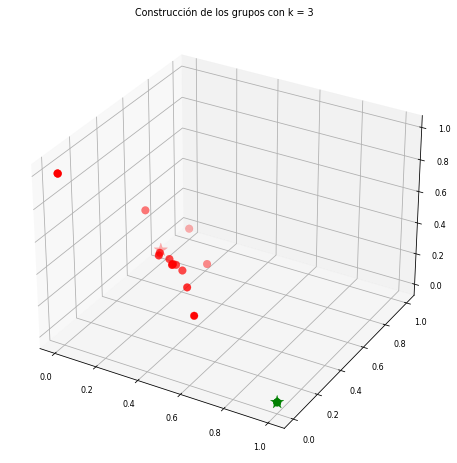

In [22]:
# Predicting the clusters
labels = kmeans.predict(S)
# Getting the cluster centers
C = kmeans.cluster_centers_
colores=['red','green']#, 'blue']
asignar=[]

for row in labels:
    asignar.append(colores[row])

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(projection='3d')
#ax = axes3d(fig)
ax.scatter(S[:, 0], S[:, 1], S[:, 2], c=asignar,s=60)
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colores, s=200)

plt.title("Construcción de los grupos con k = 3")

plt.savefig('grupos_matrizS.png')

In [23]:
grupos = kmeans.labels_
grupos

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [41]:
from sklearn.cluster import SpectralClustering

In [83]:
clustering = SpectralClustering(n_clusters=3, assign_labels='discretize', random_state=0).fit(S)
clustering.labels_

NameError: name 'SpectralClustering' is not defined

In [84]:
grupo0 = []
grupo1 = []
grupo2 = []

for idx, valor in enumerate(grupos):
    if valor == 0:
        grupo0.append(idx)
    elif valor == 1:
        grupo1.append(idx)
    else:
        grupo2.append(idx)
        
print(grupo0)
print(grupo1)
print(grupo2)

[0, 7, 16]
[1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15]
[]


In [85]:
dict_grupo0 = {}

for estud in grupo0:
    for (stud, att, index, obs, res) in sorted(data, key=lambda x: x[1]):
        if stud == estud:
            K = np.dot(S[stud, :], T[:, att, :])
            promedio = np.sum(K) / len(K)
            if estud in dict_grupo0:
                dict_grupo0[stud].append(promedio)
            else:
                dict_grupo0[stud] = [promedio]

In [86]:
dict_grupo1 = {}

for estud in grupo1:
    for (stud, att, index, obs, res) in sorted(data, key=lambda x: x[1]):
        if stud == estud:
            K = np.dot(S[estud, :], T[:, att, :])
            promedio = np.sum(K) / len(K)
            if estud in dict_grupo1:
                dict_grupo1[estud].append(promedio)
            else:
                dict_grupo1[estud] = [promedio]

In [87]:
dict_grupo2 = {}

for estud in grupo2:
    for (stud, att, index, obs, res) in sorted(data, key=lambda x: x[1]):
        if stud == estud:
            K = np.dot(S[estud, :], T[:, att, :])
            promedio = np.sum(K) / len(K)
            if estud in dict_grupo2:
                dict_grupo2[estud].append(promedio)
            else:
                dict_grupo2[estud] = [promedio]

In [89]:
dict_grupo1

{1: [0.7280475088522753,
  0.7474436202840046,
  0.7383578080714635,
  0.7060427697231825,
  0.8279198559645329,
  0.9047189971144363,
  0.8655829049834303,
  0.8988843230053956,
  0.8924809011052556,
  0.7511822443326696,
  0.7291149942735764,
  0.9220931870105528,
  0.8498350099741504,
  0.7872631370914434,
  0.7597488910797742,
  0.9283405730492721,
  0.8653237585505631],
 2: [0.8897230099959647,
  0.7173775006146008,
  0.6171026874639556,
  0.8814471890500755,
  0.8757402029168901,
  0.9369001516430406,
  0.8487225971158929,
  0.8591836974100403,
  0.8068967782238581,
  0.663271408641388,
  0.864611582807934,
  1.0256639319540302,
  0.7410713817329899,
  0.5808924058650073,
  0.7830776095422243,
  1.0169300835561583],
 3: [0.7115827598170191,
  0.7538084736661778,
  0.7412549523333916,
  0.6947608287936968,
  0.8293165645751275,
  0.9069341369684187,
  0.8641719772403119,
  0.9096835972643997,
  0.8972081772021137,
  0.7680833452104224,
  0.7178535442627381,
  0.9163688854437518,
 

---

## Conceptos

In [24]:
prom_conceptos_attempts = []
for i in range(0,19):
    cont = 0
    K = [0.0, 0.0, 0.0, 0.0, 0.0]
    for (student, attempt, index, obs, resource) in data:
        if attempt == i:
            K = K + np.dot(S[student, :], T[:, attempt, :]) # esto nos da un vector de dimension 1x5
            cont += 1
    promedioK = K / cont
    prom_conceptos_attempts.append(promedioK)

print('\nPromedios de los conceptos por attempt')
print(prom_conceptos_attempts)


Promedios de los conceptos por attempt
[array([0.41031066, 0.82161137, 0.61853141, 0.65665717, 0.60188963]), array([0.41131255, 0.82234395, 0.887476  , 0.69682616, 1.10050196]), array([0.69101177, 0.82241466, 0.94764586, 0.48090538, 1.1351354 ]), array([0.70441085, 0.78139367, 0.98147757, 0.46609454, 1.03510919]), array([0.70318128, 0.87240542, 0.96172722, 0.76228782, 1.01577445]), array([0.74365949, 0.91576053, 1.11064997, 0.80340231, 0.99375209]), array([0.99754101, 0.91722072, 1.11640849, 0.78533145, 0.86452325]), array([1.00200772, 1.05107829, 1.1710623 , 0.76116384, 0.79615342]), array([0.78331934, 1.05301534, 1.24954059, 0.74150205, 0.98355517]), array([0.67580215, 0.74450738, 1.25454769, 0.68008719, 0.86119768]), array([0.5925304 , 0.86182214, 0.77194733, 0.68795542, 0.9963988 ]), array([0.84454273, 1.03990778, 0.99654365, 0.69029329, 1.06638997]), array([0.84362065, 0.95470798, 0.85391738, 0.8618074 , 1.04722169]), array([0.89995217, 0.95818668, 0.85843804, 0.7911828 , 0.82783

In [24]:
prom_conceptos_attempts_grupo0 = []

for i in range(0,19):
    cont = 0
    K = [0.0, 0.0, 0.0, 0.0, 0.0]
    for (student, attempt, index, obs, resource) in data:
        if attempt == i and student in grupo0:
            K = K + np.dot(S[student, :], T[:, attempt, :]) # esto nos da un vector de dimension 1x5
            cont += 1
    promedioK = K / cont
    prom_conceptos_attempts_grupo0.append(promedioK)

print('\nPromedios de los conceptos por attempt')
print(prom_conceptos_attempts_grupo0)

TypeError: unsupported operand type(s) for /: 'list' and 'int'

In [65]:
prom_conceptos_attempts_grupo1 = []

for i in range(0,16):
    cont = 0
    K = [0.0, 0.0, 0.0, 0.0, 0.0]
    for (student, attempt, index, obs, resource) in data:
        if attempt == i and student in grupo1:
            K = K + np.dot(S[student, :], T[:, attempt, :]) # esto nos da un vector de dimension 1x5
            cont += 1
    #promedioK = [x / cont for x in K if cont != 0]
    promedioK = K / cont
    prom_conceptos_attempts_grupo1.append(promedioK)

print('\nPromedios de los conceptos por attempt')
print(prom_conceptos_attempts_grupo1)


Promedios de los conceptos por attempt
[array([0.91250552, 1.84783234, 0.84142131, 1.82499348, 1.53220466]), array([0.48867015, 1.39636148, 0.71974003, 0.24015003, 0.99010224]), array([1.10158118, 0.79851569, 0.96664455, 0.4660884 , 1.3512383 ]), array([0.41043235, 0.8430737 , 0.8687843 , 1.18801146, 0.46225845]), array([1.05096612, 0.9517392 , 1.50062616, 0.88498142, 1.27117293]), array([0.53179079, 0.73973194, 0.7513586 , 0.80968405, 1.43294757]), array([1.1024118 , 1.1520194 , 1.21899618, 0.45947843, 0.86765837]), array([1.17545517, 1.57155921, 0.87522323, 0.6058526 , 0.49323555]), array([0.32419326, 1.41175244, 1.28724796, 0.57965214, 0.59520704]), array([0.55768664, 0.14127108, 0.70124034, 0.99318024, 0.53341941]), array([0.23891846, 1.15782294, 0.58882975, 1.0345503 , 1.22266448]), array([1.1909883 , 1.16826471, 1.33644215, 0.55029827, 1.07781008]), array([0.87465882, 0.66279561, 0.72875318, 0.78734841, 1.36113878]), array([0.39828233, 1.37419226, 1.29634442, 0.86032945, 0.90288

In [66]:
prom_conceptos_attempts_grupo2 = []

for i in range(0,14):
    cont = 0
    K = [0.0, 0.0, 0.0, 0.0, 0.0]
    for (student, attempt, index, obs, resource) in data:
        if attempt == i and student in grupo2:
            K = K + np.dot(S[student, :], T[:, attempt, :]) # esto nos da un vector de dimension 1x5
            cont += 1
    #promedioK = [x / cont for x in K if cont != 0]
    promedioK = K / cont
    prom_conceptos_attempts_grupo2.append(promedioK)

print('\nPromedios de los conceptos por attempt')
print(prom_conceptos_attempts_grupo2)


Promedios de los conceptos por attempt
[array([0.76622449, 1.49822139, 0.89072127, 1.41873881, 1.25512329]), array([0.4056431 , 0.82414703, 0.89018904, 1.39343252, 1.81555713]), array([0.71934803, 0.65063503, 0.81694978, 0.21275471, 1.57943921]), array([ 0.14229298,  1.13749796,  0.38187212, -0.20552841,  1.06975129]), array([0.73127017, 1.3295077 , 1.32971958, 0.91653606, 1.18686563]), array([0.60507729, 1.26256601, 0.91200143, 0.87279115, 1.37283113]), array([1.2574532 , 0.48525964, 0.39911059, 0.65944908, 1.18930217]), array([1.27080507, 1.5096234 , 0.94809754, 0.56165246, 1.42435864]), array([0.88949909, 0.89970424, 1.78658363, 0.72806776, 1.1695822 ]), array([0.33463546, 1.38742287, 1.53133416, 0.55200235, 1.73059183]), array([0.46180223, 0.48930863, 0.81344553, 0.17321295, 1.01318796]), array([0.75288449, 1.45976947, 0.87488821, 0.98109202, 1.35723886]), array([0.64319907, 1.41389043, 0.99622295, 0.91892191, 0.64775949]), array([0.91108093, 1.5663443 , 0.86704977, 0.25558028, 0.

---

## Peso de los recursos

In [69]:
for i in range(0,12):
    print(f'Peso del recurso {i} por concepto:')
    print(Q[:, i])
    print('----------')

Peso del recurso 0 por concepto:
[0.49469266 0.         0.         0.         0.50530734]
----------
Peso del recurso 1 por concepto:
[0.00475102 0.         0.         0.99287585 0.00237313]
----------
Peso del recurso 2 por concepto:
[0.36715341 0.12416654 0.28223808 0.22598402 0.00045796]
----------
Peso del recurso 3 por concepto:
[0. 0. 0. 1. 0.]
----------
Peso del recurso 4 por concepto:
[9.98221590e-01 5.05449905e-04 3.88286253e-04 5.49535651e-04
 3.35138187e-04]
----------
Peso del recurso 5 por concepto:
[0.13652819 0.19879148 0.18039548 0.23067753 0.25360732]
----------
Peso del recurso 6 por concepto:
[0.00000000e+00 0.00000000e+00 9.99592735e-01 0.00000000e+00
 4.07265113e-04]
----------
Peso del recurso 7 por concepto:
[7.12583087e-04 2.94620104e-04 9.97702468e-01 2.82486694e-04
 1.00784204e-03]
----------
Peso del recurso 8 por concepto:
[5.72643419e-04 8.11944571e-04 9.56186978e-01 8.46734452e-04
 4.15816998e-02]
----------
Peso del recurso 9 por concepto:
[4.93398059e-0

---

conocimiento promedio adquirido por cada recurso

In [91]:
for i in range(0,12):
    conocimiento = 0.0
    contador = 0
    for (student, attempt, question, obs, resource) in data:
        if i == question:
            conocimiento = conocimiento + np.dot(np.dot(S[student, :], T[:, attempt, :]), Q[:, question])
            contador += 1
    
    promedio_conocimiento_recurso = conocimiento / contador
    print(promedio_conocimiento_recurso)
    

0.7834692391896704
0.48546640467773244
0.8959825388123855
0.6566999133327813
0.7780093097664287
0.8065930230211774
0.8186430083231858
0.8126983705698272
0.8375888445718763
0.8657443930793264
0.7833203702187224
0.8888407170267598


In [84]:
for i in range(0,8):
    conocimiento = 0.0
    contador = 0
    for (student, attempt, question, obs, resource) in data:
        if i == question:
            conocimiento = conocimiento + np.dot(np.dot(S[student, :], T[:, attempt, :]), E[:, question])
            contador += 1
    
    promedio_conocimiento_recurso = conocimiento / contador
    print(promedio_conocimiento_recurso)

1.1435114955026415
0.9687268790964275
1.0298423162894728
0.9655509843393054
0.942263875099021
0.9521967361533819
1.0154054428180523
0.8515035353210447


In [88]:

for (student, attempt, question, obs, resource) in sorted(data, key=lambda x: x[1]):
    if student == 5 and question == 0:
        conocimiento = 0
        conocimiento = np.dot(np.dot(S[student, :], T[:, attempt, :]), Q[:, question])
        print(conocimiento)


1.1409856994169814
1.0019789128424694
